In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

# Преподобный Байес и его секта

![](https://www.investigacionyciencia.es/images/13450/imageFacebookThumbnail.jpg)

## Восстановление плотности

**Дано**:
* обучающая выборка $X^{\ell}=(x_i, y_i)_{i=1}^{\ell}$

**Найти**:
* совместную плотность признаков-ответов $p(x, y)$

Если бы мы смогли найти эту плотность, то были бы в шоколаде... На практике всё сложнее.

## Непараметрические методы восстановления плотности

Рассмотрим всё на одномерной картинке: так будет понятнее. Давайте нагенерируем немножечко данных:

In [17]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

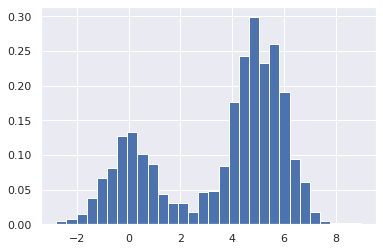

In [18]:
hist = plt.hist(x, bins=30, density=True)

Красота, не правда ли? :) Два выраженных пика, все дела.

Но от разбиения на корзины зависит слишком многое. Смотрим:

In [19]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

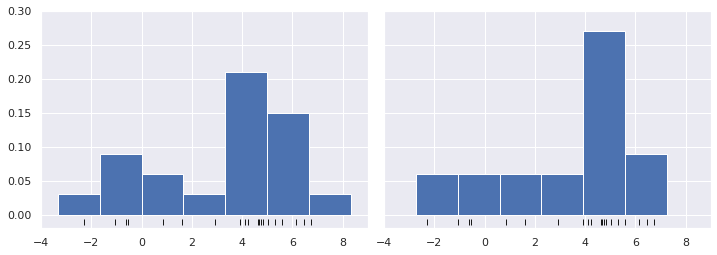

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

Данные одни и те же, но как-то правая картинка даёт совсем неправильное представление о том, что происходит.

Хочется учитывать не просто количество объектов, попавщее в корзину, а именно настоящую плотность. Давайте попробуем немножечко сгладить:

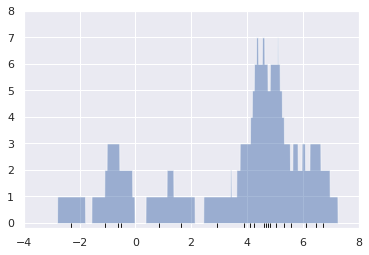

In [21]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

Получилось получше! Но всё равно немного угловато. Давайте сгладим каким-нибудь ядром:

(-4.0, 8.0, -0.2, 5.0)

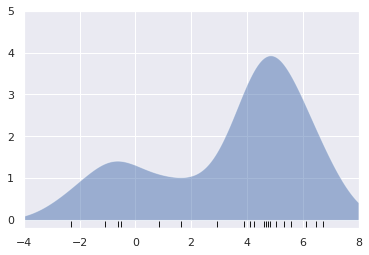

In [22]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5])

О, вот так уже совсем похоже на реальное положение дел.

Благо, в sklearn есть метод, который делает всё за нас. Занимаемся мы Kernel Density Estimation'ом (KDE), что и отражается в названии метода:

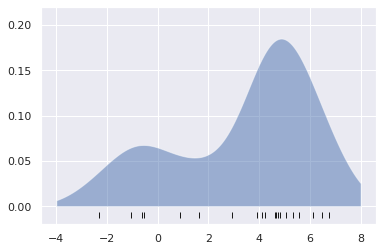

In [36]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=1.123, kernel='gaussian')
kde.fit(x[:, None])

logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.ylim(-0.02, 0.22)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

Если поиграться с параметром bandwidth (ширина окна), то можно заметить, что далеко не для всех его значений плотность выглядит так радужно, как хотелось бы.

Т.к. этот параметр так сильно влияет на наш метод, хорошо бы найти его "оптимальное" значение... Благо, на помощь приходит кросс-валидация! И что особенно радостно, в sklearn есть стандартные для этого средства!

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None])

GridSearchCV(cv=LeaveOneOut(), estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825594,  0.29150531,  0.305385...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])})

In [25]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

## Параметрические методы восстановления плотности

В таких методах мы сами придумываем модель плотности вероятности, остаётся лишь подобрать параметры.

Пусть у нас модель
$$
    p(x)=\phi(x; \theta)
$$

Предполагаем, что все объекты выборки распределены независимо друг от друга и подбираем $\theta$ с помощью метода максимального правдоподобия:
$$
\theta = \arg\max_{\theta} \sum\limits_{i=1}^{\ell}\ln\phi(x_i; \theta)
$$

Дифференцируем, приравниваем к 0, получаем оценки.

## Байесовский классификатор

Вообще, мы хотим решать задачу классификации:
$$
    y = \arg\max_{y}p(y|x)
$$

Если бы мы умели вот так взять и выписать условную вероятность $y$ при условии $x$... Давайте лучше попробуем перевернуть всё немножечко с ног на голову.

Вспоминаем формулу Байеса:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/1920px-Bayes%27_Theorem_MMB_01.jpg)

$$
p(y|x) = \frac{p(x|y)p(y)}{p(x)} \propto p(x|y)p(y)
$$

Кажется, что $p(x|y)$ и $p(y)$ посчитать намного проще, чем $p(y|x)$

## Наивный байесовский классификатор

**НАИВНО** предположим, что все признаки у нас независимы. Тогда
$$
p(x|y)p(y)=p(y)\prod\limits_{i=1}^mp(x^i|y)
$$

Как правило, $p(y)$ - это частоты ответов, а $p(x^i|y)$ зависит от признака.

### Дискретный случай

Пусть, не ограничивая общности, $x^i$ может принимать различные значения от 1 до $k$. И пусть $n_j$ - сколько раз в обучающей выборке встретился этот признак со значением $j$
* Maximum likelihood
$$
            \hat p(x^i|y) = \frac{n_{x^i}}{\sum\limits_{j=1}^k n_j}
$$
* Add-one smoothing
$$
            \hat p(x^i|y) = \frac{1 + n_{x^i}}{k + \sum\limits_{j=1}^k n_j}		
$$


* Adaptive/Laplace smoothing
$$
            \hat p(x^i|y) = \frac{\alpha_{x^i} + n_{x^i}}{\sum\limits_{j=1}^k (\alpha_j + n_j)}		
$$

Вы не поверите, но всё это соответствует параметрическому методу восстановление плотности, если считать, что данные распределены мультиномиально. Причём просто отличается заданием априорной вероятности на распределение :) За подробностями - в курс байесовских методов в следующем семестре!

### Непрерывный случай

Тут тоже можно использовать всякие среднее, медиану (мы уже знаем, каким распределениям они соответствуют), а также KDE, рассмотренный нами выше :)

Сгенерируем немного данных:

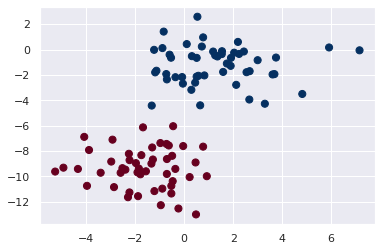

In [26]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

Для наивных байесовских классификаторов в sklearn есть метод:

In [27]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y)

GaussianNB()

**Задание 1 (1 балл), разминка.** Прикрутите нашу визуализацию разделяющей гиперплоскости к байесовскому классификатору. Почему она имеет такой вид? Какой он будет в общем случае, если мы в качестве распределения берём гауссово и решаем задачу двухклассовой классификации?

GaussianNB()

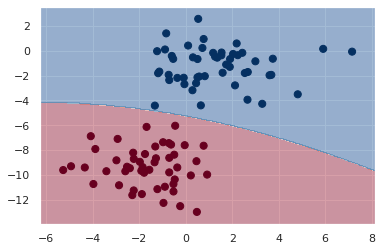

In [28]:
### YOUR CODE HERE

def get_grid(data, step=0.05):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, step),
                       np.arange(y_min, y_max, step))
  
def plot_model(X, y, clf, proba=False):
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, predicted, cmap='RdBu', alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    return clf

plot_model(X, y, model)

YOUR ANSWER HERE

Разделяющая поверхность на этом графике похожа на параболу (или гиперболу).

В общем случае она будет иметь вид гиперповерхности второго порядка, потому что левая часть уравнения, которое я нашёл в учебнике, квадратична по $x$.

## А теперь в бой!

Давайте сравним "наивный" байесовский классификатор и не такой уж и наивный.

Для этого загрузим набор рукописных цифр и попробуем решить задачу многоклассовой классификации с помощью "наивного" байесовского классификатора:

In [40]:
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score

digits = load_digits()
cross_val_score(GaussianNB(), digits.data, digits.target, cv=5).mean()

0.8069281956050759

Неплохо... Но можно лучше!

**Задание 2 (2 балла), "наивный" повзрослел**. Давайте избавимся от детской наивности и научим байесовский классификатор вести себя по-мужски!
* разделите тренировочную выборку по меткам классов

* для каждого куска получите распределение $p(x|y)$, используя KDE

* пусть $p(y)$ будет равно доли объектов с классом $y$

* при предсказании, выдавайте класс с максимальной апостериорной вероятностью, то есть с максимумом $p(x|y)p(y)$

* чтобы подобрать оптимальное значение ширины окна стандартной кросс-валидацией, оберните это всё в класс с интерфейсом ниже

In [160]:
datas_by_target = [[] for target in range(10)]
for dat, tar in zip(digits.data, digits.target):
    datas_by_target[tar].append(dat)
for tar in range(10):
    datas_by_target[tar] = np.array(datas_by_target[tar])

In [159]:
datas_by_target[0][0].shape

(64,)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        ### YOUR CODE HERE
        self.datas_by_target = [[] for target in range(10)]
        for dat, tar in zip(digits.data, digits.target):
            self.datas_by_target[tar].append(dat)

        
    def fit(self, X, y):
        ### YOUR CODE HERE
        self.distr_by_target = [
            for tar in 
        ]
        
        return self
        
    def predict_proba(self, X):
        ### YOUR CODE HERE
        pass
        
    def predict(self, X):
        ### YOUR CODE HERE
        pass